## This notebook is for testing the SDK before using any scripts for data retrieval / live feed
- Make sure you have the .env file with the corrent variable names listed below before running the code

In [1]:
# Authentication for streaming data
from neurosity import NeurositySDK
from dotenv import load_dotenv
import os

load_dotenv()

neurosity = NeurositySDK({
    "device_id": os.getenv("NEUROSITY_DEVICE_ID")
})

neurosity.login({
    "email": os.getenv("NEUROSITY_EMAIL"),
    "password": os.getenv("NEUROSITY_PASSWORD")
})

In [2]:
# checking the info from the SDK
info = neurosity.get_info()
print(info)

OrderedDict({'channelNames': ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5'], 'channels': 8, 'deviceId': 'e425ea92bcd7bdae65a5c2b07322433d', 'deviceNickname': 'Emulator-E42', 'emulator': True, 'manufacturer': 'Neurosity, Inc', 'model': 'Emulator 2', 'modelName': 'Emulator', 'modelVersion': '2', 'osVersion': '14.5.0', 'samplingRate': 250})


# Raw Brainwaves Data

In [3]:
# Retrieving raw brainwaves and storing 1 epoch
import time
sample = 0

def callback(data):
    global sample
    sample = data
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(1)

unsubscribe()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# What one epoch looks like
# print(sample)

# Storing & Visualizing 
channels = ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5']
data = np.array(sample['data'])  
print(data)
print(data.shape)
print(sample['info'])

[[ 9.01902984e+00 -2.12642347e+00 -1.48923601e+01 -2.08870005e+01
  -1.61577387e+01 -1.82362850e+00  1.65008221e+01  2.86961048e+01
   2.64370046e+01  9.94142667e+00 -1.19145865e+01 -2.74413021e+01
  -2.89402527e+01 -1.69154373e+01  2.38564997e-02  1.26094309e+01
   1.65533256e+01  1.28349555e+01  8.57984262e+00  9.13960799e+00
   1.13862221e+01  1.13728480e+01  7.86750375e+00  2.41508666e+00
   1.91152762e+00]
 [ 5.22337645e+00  6.67085318e+00  3.39216581e+00 -2.59744064e+00
  -7.61042230e+00 -7.06973513e+00 -4.49149950e-01  6.18995683e+00
   6.00821470e+00 -1.98198393e+00 -1.19929552e+01 -1.59762282e+01
  -9.34996052e+00  4.73961423e+00  1.49370776e+01  1.21253428e+01
  -1.95310383e+00 -1.95750421e+01 -3.18451112e+01 -3.21559404e+01
  -2.10513458e+01 -4.15762327e+00  1.18832971e+01  2.00172804e+01
   1.55698256e+01]
 [ 1.06118453e+01  1.59030232e+01  1.95625441e+01  1.95587986e+01
   1.36965235e+01  4.02469231e+00 -4.73828537e+00 -9.51565276e+00
  -8.67047432e+00 -2.05713522e+00  5.9

### Epoch Structure
-  the data is recieved as 8 rows, with each row being a channel, and each column being 1 timestamp with the duration between each other depending on the`samplingRate` attribute. 
    E.g. `samplingRate = 250` means 250 samples per second, each sample being 4 ms, and each epoch being 100 ms
- The values themselves range from -40 to +32 microvolts

In [5]:
# Accumilating 5 seconds worth of epochs
data = np.zeros((8,1))
def callback(new):
    new = np.array(new['data'])
    global data
    data = np.concatenate((data,new), axis=1)
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(5)

unsubscribe()
print(data)
print(data.shape)

[[  0.           8.98124052   4.03951219 ... -19.46861696 -13.83255521
   -8.72164262]
 [  0.          23.88393245  11.70604704 ... -19.42744234 -14.10136839
   -4.39806533]
 [  0.         -16.83043654 -25.90859641 ...  -7.77554905 -10.76240811
  -10.62936339]
 ...
 [  0.         -10.61773942 -15.97798311 ...   6.76269795   2.03837109
   -2.52260612]
 [  0.         -23.02799295  -9.04638828 ...  -2.83428284 -10.63514203
  -12.5038801 ]
 [  0.         -17.3354041  -16.44256433 ...  20.08184627   9.93544111
   -1.63188701]]
(8, 1076)


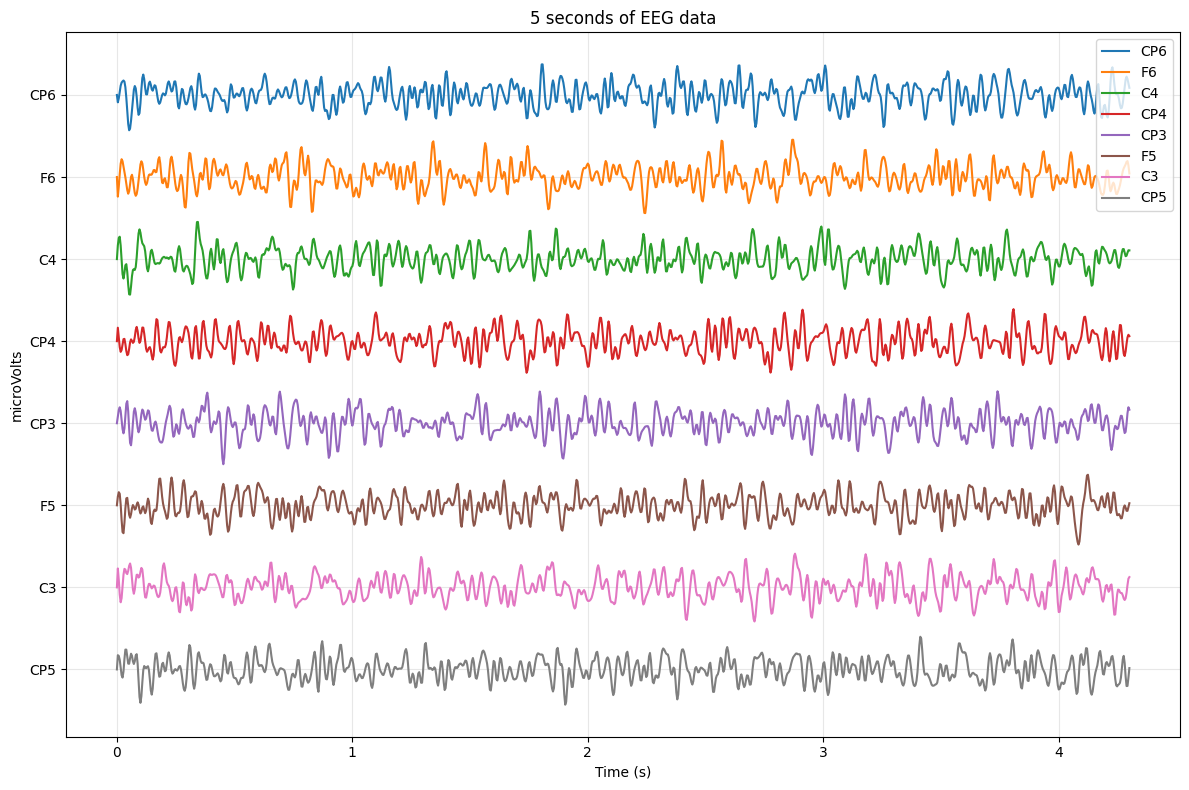

In [6]:
# Visualizing the 5 second window
n_channels, n_samples = data.shape
time = np.arange(n_samples) / 250  # assume 250 Hz sampling rate (adjust!)

plt.figure(figsize=(12, 8))

# Plot each channel with vertical offsets so they don’t overlap
offset = 100  # adjust spacing between signals
for i in range(n_channels):
    plt.plot(time, data[i] + i * offset, label=channels[i])

plt.yticks([i * offset for i in range(n_channels)], channels)
plt.gca().invert_yaxis()

plt.title("5 seconds of EEG data")
plt.xlabel("Time (s)")
plt.ylabel("microVolts")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

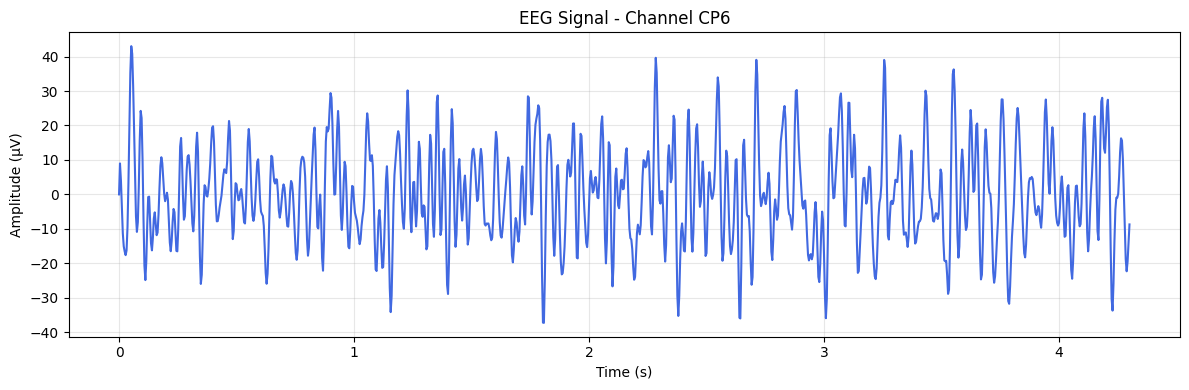

In [7]:
# Visualization for individual channels (e.g. "CP6")
channel_idx = channels.index("CP6")
channel_data = data[channel_idx]

# Sampling rate (adjust to your device)
fs = 250  
time = np.arange(channel_data.shape[0]) / fs

plt.figure(figsize=(12, 4))
plt.plot(time, channel_data, color="royalblue")
plt.title(f"EEG Signal - Channel {channels[channel_idx]}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Absolute Power

In [8]:
# Retrieve Absolute Power (AP) brainwaves
import time

ap_sample = None

def ap_callback(data):
    global ap_sample
    ap_sample = data
    print("Absolute Power Update:", data)

# To subscribe to absolute power stream
unsubscribe_ap = neurosity.brainwaves_power_by_band(ap_callback)

# Run for a few seconds
time.sleep(5)

# Stop the subscription
unsubscribe_ap()

print(f"Final Absolute Power Sample: {ap_sample}")

Absolute Power Update: {'data': {'alpha': [3.473826815008705, 3.5607399981217096, 3.0552236767778402, 4.2759374829333, 2.9612016404727193, 2.1020957481044675, 4.907288550956928, 1.5460549892977078], 'beta': [3.0838469706390743, 2.270956469976034, 2.0663643054002163, 1.75603298848118, 3.249330487788699, 2.7865451729318056, 2.1489879790716633, 3.5543491700629946], 'delta': [1.5056757121019753, 2.092140562879382, 2.737366336355692, 5.16327496247216, 1.2249307192723693, 1.1859008403381384, 1.473752250274042, 2.9851501433253445], 'gamma': [0.5632579364110261, 0.8073122193773027, 0.4848355048106669, 0.6375132392965487, 0.6588985134488962, 0.670170611674298, 0.7666577673768171, 0.8254159322778932], 'theta': [2.493681193600157, 2.87719921415696, 5.6831243503487325, 2.1034423338387485, 1.0726666303803143, 2.212317686862427, 1.2792937540699336, 1.7849240698931694]}, 'label': 'powerByBand'}
Absolute Power Update: {'data': {'alpha': [3.4625430690909424, 2.281219088711128, 1.4016686425654428, 2.490

## Dictionary Structure
- there are 5 frequencies, and each contains an array of 8 elements for the 8 channels, showing the power in each channel

In [9]:

print(ap_sample['data'])


{'alpha': [3.1648798412953005, 2.3874551390046324, 5.681596330517539, 5.968647514128706, 2.2418821897119487, 1.7724995175193479, 3.161172516271442, 2.148526202447647], 'beta': [3.3615765451455406, 2.8266659799862968, 2.518878611645266, 2.028805550509841, 3.454120308047971, 3.8517352802207423, 2.612394812573067, 3.2039403441949723], 'delta': [1.0651175755040359, 3.0032911873796837, 1.4921859870313072, 2.117472541266083, 0.9843433308429885, 1.6475598966537517, 3.211385498153371, 0.7489175972589068], 'gamma': [0.6665051334601549, 0.4988698640638257, 0.4639808779925734, 0.5092693279195548, 0.7497939304724189, 0.7411467027331651, 0.6762252821802139, 0.5920181666576028], 'theta': [2.9653402248729552, 3.8590220944449056, 3.52758311854738, 3.379979079321097, 1.1959230039533688, 1.6141322563019405, 3.107096095095378, 1.0588642796581276]}


# Calm/Focus Data

## Neurosity.calm() quick explanation:

neurosity.calm() streams a probability (0–1) that represents how calm the user is, based on EEG signals.

Difference from raw/absolute power:
Instead of giving you raw brainwave amplitudes (e.g. alpha, beta, gamma), it already applies Neurosity’s built-in model to estimate calmness.

A possible use case that we can use: 
We may define relaxed via low beta & high alpha, for example.

In [10]:
# Retrieve Focus/Calm Probability for 5 seconds
import time

def callback(data):
    print("Probability:", data)

# subscribing to focus and calm streams
focus_unsubscribe = neurosity.focus(callback)
calm_unsubscribe = neurosity.calm(callback)
# Run for a few seconds
time.sleep(5)

# Stop the subscription
focus_unsubscribe()
calm_unsubscribe()
print(f"Final Focus Sample: {sample}")

Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.4660126045218971, 'timestamp': 1757228299948}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.40558059023385035, 'timestamp': 1757228300642}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.43722713704749055, 'timestamp': 1757228301086}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.3829100754935376, 'timestamp': 1757228301760}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.5249453978229961, 'timestamp': 1757228302203}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.24198610296390574, 'timestamp': 1757228302897}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.5207215018217419, 'timestamp': 1757228303345}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.3601779876322613, 'timestamp': 1757228304033}
Probability: {'label': 'focus', 'metric': 'awareness', 'p

In [11]:
# Test out callback function for data retrieval
focusList = []
def callback_focus(data):
    global focusList
    focusList.append([data['timestamp'], {data['label']: data['probability']}])

f_unsubscribe = neurosity.focus(callback_focus)
time.sleep(3)
f_unsubscribe()

print(focusList)

[[1757228306749, {'focus': 0.559420348939585}], [1757228307904, {'focus': 0.5571599628616034}], [1757228309042, {'focus': 0.42554433553329263}]]


## Accelerometer() explanation: 

Each epoch has three acceleration values: x, y and z. For example: 

In [12]:
{
  "x": -0.02,
  "y": 0.99,
  "z": 0.07,
  "timestamp": 1635724527000
}


{'x': -0.02, 'y': 0.99, 'z': 0.07, 'timestamp': 1635724527000}

                                        
- The unit is expressed in g, where 1 g corresponds to the acceleration due to gravity on Earth.

- Values reflect both gravitational acceleration and any movement-induced acceleration.

- Accelerometer() focuses on movement, rather than specific brainwaves. 

##### By looking at accelerometer epochs, one can: 

- Detect when the user is moving.

- Flag those EEG segments as less reliable.

- Clean your dataset by removing or correcting for motion artifacts.


In [13]:
# Callback for accelerometer
def accelerometer_test(data):
    ts = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(data['timestamp']/1000))
    print(f"[ACCEL] {ts} | x={data['x']:.3f}, y={data['y']:.3f}, z={data['z']:.3f}")

# Subscribe for 5 seconds
unsubscribe = neurosity.accelerometer(accelerometer_test)
print("Collecting accelerometer epochs for 5 seconds...")
time.sleep(5)
unsubscribe() 

## Kinesis() explanation: 

                                        
- Each epoch represents a prediction of a user action such as blink or nod. 

- The SDK provides a label for each of the discrete user actions. 

For example: 

In [14]:
{
  "label": "jump",
  "confidence": 0.87,
  "timestamp": 1635724527000
}


{'label': 'jump', 'confidence': 0.87, 'timestamp': 1635724527000}

- label:  Indicates the specific action detected. This can be one of the standard gestures (e.g., push, pull, left, right) or a label we have trained (e.g., jump, blink, nod).

- confidence:  A value between 0 and 1 that expresses how certain the system is about the detected action.

- timestamp : Records the exact moment the prediction was made, given in epoch time (milliseconds).

In [15]:
# Callback for kinesis
def kinesis_test(data):
    ts = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(data['timestamp']/1000))
    print(f"[KINESIS] {ts} | label={data['label']} | confidence={data['confidence']:.2f}")

# Subscribe for 5 seconds with a custom label
unsubscribe = neurosity.kinesis("jump", kinesis_test)
print("Collecting kinesis epochs for 5 seconds...")
time.sleep(5)
unsubscribe()


### PSD explanation(): 

 - Power Spectral Density (PSD) represents how the power of a signal is distributed across different frequency components.